In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import mpl, plt
import seaborn as sns
import numpy as np

In [20]:
def get_raw_data():
    raw_data = pd.read_csv("https://hilpisch.com/pyalgo_eikon_eod_data.csv", index_col=0, parse_dates=True).dropna()
    raw_data.rename(columns=lambda x: x.rstrip('.O').rstrip('.N').rstrip('=').lstrip('.'), inplace=True)
    return raw_data

get_raw_data()

,AAPL,MSFT,INTC,AMZ,GS,SPY,SPX,VIX,EUR,XAU,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.0000,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.6500,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5000,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.9000,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.1000,49.84,111.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,284.270000,157.380,59.41,1789.21,229.91,321.23,3223.38,12.67,1.1087,1498.8100,28.66,141.27
2019-12-26,289.910000,158.670,59.82,1868.77,231.21,322.94,3239.91,12.65,1.1096,1511.2979,29.08,142.38
2019-12-27,289.800000,158.960,60.08,1869.80,230.66,322.86,3240.02,13.43,1.1175,1510.4167,28.87,142.33


In [21]:
returns_drawdown_drawdownPeriod_SMA1 = []

def find_optimal_sma(SMA_1=50, SMA_2=252, instrument='EUR='):

    raw_data = get_raw_data()
    # symbol_list = list(raw_data.columns)
    # print(symbol_list)

    # print(raw_data.head())

    # raw_data.info()

    data = pd.DataFrame(raw_data[instrument])

    data.rename(columns={instrument: 'Price'}, inplace=True)
    # data.info()

    SMA1 = f'SMA{SMA_1}'
    SMA2 = f'SMA{SMA_2}'
    data[SMA1] = data['Price'].rolling(SMA_1).mean()
    data[SMA2] = data['Price'].rolling(SMA_2).mean()
    # data.tail()

    %matplotlib inline
    # print(plt.style.available)
    plt.style.use('seaborn-v0_8-whitegrid')
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['font.family'] = 'serif'

    # data.plot(title=f'EUR/USD with {SMA_1} and {SMA_2} Day SMAs', figsize=(10, 6))

    data['position'] = np.where(data[SMA1] > data[SMA2], 1, -1)
    data.dropna(inplace=True)
    # data['position'].plot(ylim=[-1.1, 1.1], title='Trading Position', figsize=(10, 6))

    data['returns'] = np.log(data['Price'] / data['Price'].shift(1))
    # data['returns'].hist(bins=30, figsize=(10, 6))

    # data['returns'].tail()

    data['sma_strategy'] = data['position'].shift(1) * data['returns']
    data[['returns', 'sma_strategy']].sum()

    # Compound Returns
    data[['returns','sma_strategy']].sum().apply(np.exp)
    strategy_returns = data[['sma_strategy']].sum().apply(np.exp)
    # print(returns, type(returns))

    # data[['returns','sma_strategy']].cumsum().apply(np.exp).plot(figsize=(10,6), title='Cumulative Returns: Buy and Hold vs. SMA Strategy')

    # Log Annualized Mean Return
    data[['returns', 'sma_strategy']].mean() * 252

    # Regular Annualized Mean Return
    np.exp(data[['returns', 'sma_strategy']].mean() * 252) - 1

    # Log Annualized Standard Deviation
    data[['returns', 'sma_strategy']].std() * 252 **0.5

    # Regular Annualized Standard Deviation
    (data[['returns', 'sma_strategy']].apply(np.exp) - 1).std() * 252 ** 0.5


    data['cumret'] = data['sma_strategy'].cumsum().apply(np.exp)
    data['cummax'] = data['cumret'].cummax()

    # data[['cumret', 'cummax']].dropna().plot(figsize=(10,6), title='Cumulative Returns and Drawdown')

    drawdown = data['cummax'] - data['cumret']
    # print(drawdown.max())

    temp_draw = drawdown[drawdown == 0]
    periods = (temp_draw.index[1:].to_pydatetime() - temp_draw.index[:-1].to_pydatetime())
    # print(periods.max())
    idx = temp_draw.index
    if len(idx) >= 2:
        returns_drawdown_drawdownPeriod_SMA1.append((float(strategy_returns.values[0]), float(drawdown.max()), periods.max().days, SMA_1))


In [33]:
def plot_optimal(optimal_sma, SMA_2 = 300, instrument='EUR='):
    
    raw_data = get_raw_data()
    # print(raw_data.head())

    # raw_data.info()

    data = pd.DataFrame(raw_data[instrument])

    data.rename(columns={instrument: 'Price'}, inplace=True)
    # data.info()
    
    SMA_1 = optimal_sma
    SMA1 = f'SMA{optimal_sma}'
    SMA2 = f'SMA{SMA_2}'
    data[SMA1] = data['Price'].rolling(SMA_1).mean()
    data[SMA2] = data['Price'].rolling(SMA_2).mean()
    # data.tail()

    %matplotlib inline
    # print(plt.style.available)
    plt.style.use('seaborn-v0_8-whitegrid')
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['font.family'] = 'serif'

    data.plot(title=f'{instrument} with {SMA_1} and {SMA_2} Day SMAs', figsize=(10, 6))

    data['position'] = np.where(data[SMA1] > data[SMA2], 1, -1)
    data.dropna(inplace=True)
    # ax = data['position'].plot(ylim=[-1.1, 1.1], title='Trading Position', figsize=(10,6))
    ax = data['position'].plot(ylim=[-1.1, 1.1], title=f'{instrument} - Trading Position', figsize=(10, 6))
    ax.set_xlim(pd.Timestamp('2010-01-01'), pd.Timestamp('2020-01-01'))

    data['returns'] = np.log(data['Price'] / data['Price'].shift(1))
    data['returns'].hist(bins=30, figsize=(10, 6))

    # data['returns'].tail()

    data['sma_strategy'] = data['position'].shift(1) * data['returns']
    data[['returns', 'sma_strategy']].sum()

    # Compound Returns
    # print(data[['returns','sma_strategy']].sum().apply(np.exp))
    data[['returns','sma_strategy']].cumsum().apply(np.exp).plot(figsize=(10,6), title=f'{instrument} - Cumulative Returns: Buy and Hold vs. SMA Strategy')

    # Log Annualized Mean Return
    data[['returns', 'sma_strategy']].mean() * 252

    # Regular Annualized Mean Return
    np.exp(data[['returns', 'sma_strategy']].mean() * 252) - 1

    # Log Annualized Standard Deviation
    data[['returns', 'sma_strategy']].std() * 252 **0.5

    # Regular Annualized Standard Deviation
    (data[['returns', 'sma_strategy']].apply(np.exp) - 1).std() * 252 ** 0.5


    data['cumret'] = data['sma_strategy'].cumsum().apply(np.exp)
    data['cummax'] = data['cumret'].cummax()

    data[['cumret', 'cummax']].dropna().plot(figsize=(10,6), title=f'{instrument} - Cumulative Returns and Drawdown')

    drawdown = data['cummax'] - data['cumret']
    # print(drawdown.max())

    temp_draw = drawdown[drawdown == 0]
    periods = (temp_draw.index[1:].to_pydatetime() - temp_draw.index[:-1].to_pydatetime())
    # print(periods.max())

In [ ]:
SMA_1 = 12
SMA_2 = 300
instrument_optimal_config = {}
raw_data = get_raw_data()
instrument_list = raw_data.columns.tolist()
# print(instrument_list)

for instrument in instrument_list:
    returns_drawdown_drawdownPeriod_SMA1 = []
    optimal_config = {}
    for sma1 in range(SMA_1, SMA_2, 2):    
        find_optimal_sma(SMA_1=sma1, SMA_2=SMA_2, instrument=instrument)
    
    # Max Returns for each asset
    returns_drawdown_drawdownPeriod_SMA1 = sorted(returns_drawdown_drawdownPeriod_SMA1, key=lambda x: x[0], reverse=True)
    optimal_sma = returns_drawdown_drawdownPeriod_SMA1[0][3]
    optimal_config['Max Returns SMA_1'] = optimal_sma

    # Min Drawdown for each asset
    returns_drawdown_drawdownPeriod_SMA1 = sorted(returns_drawdown_drawdownPeriod_SMA1, key=lambda x: x[1])
    optimal_sma = returns_drawdown_drawdownPeriod_SMA1[0][3]
    optimal_config['Min Drawdown SMA_1'] = optimal_sma

    # Min Drawdown Period for each asset
    returns_drawdown_drawdownPeriod_SMA1 = sorted(returns_drawdown_drawdownPeriod_SMA1, key=lambda x: x[2])
    optimal_sma = returns_drawdown_drawdownPeriod_SMA1[0][3]
    optimal_config['Min Drawdown Period SMA_1'] = optimal_sma

    instrument_optimal_config[instrument] = optimal_config
    

['AAPL', 'MSFT', 'INTC', 'AMZ', 'GS', 'SPY', 'SPX', 'VIX', 'EUR', 'XAU', 'GDX', 'GLD']


e:\Code\PyAlgoTrading\.venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


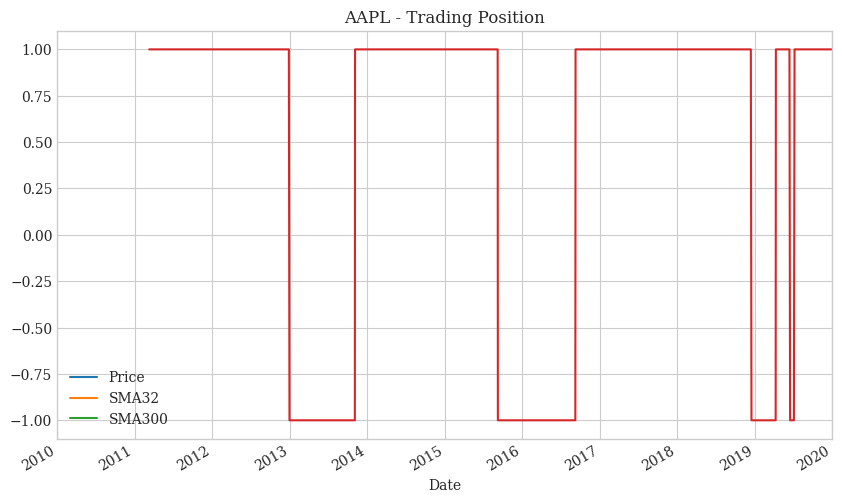

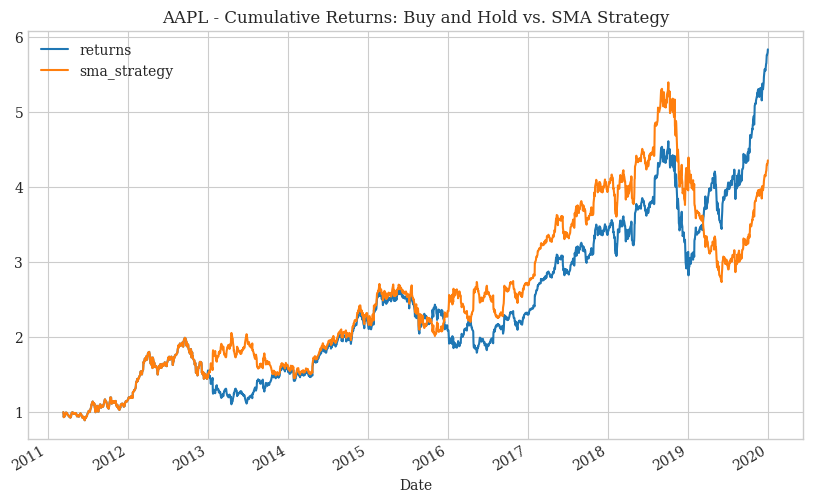

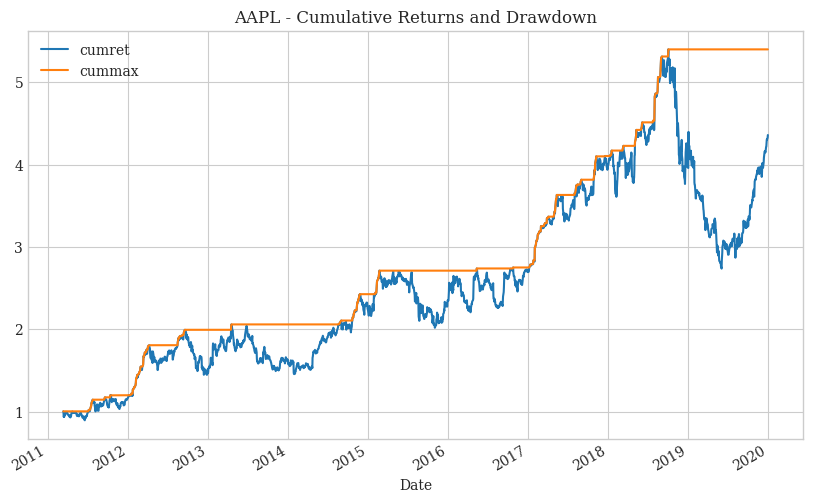

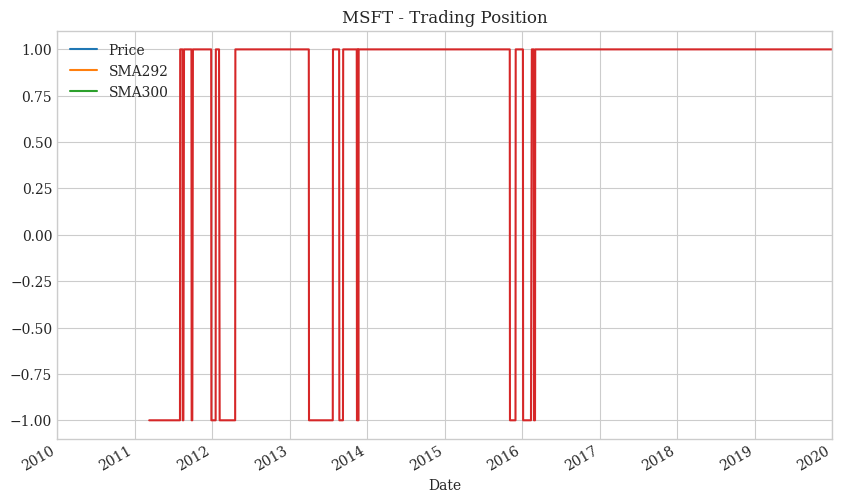

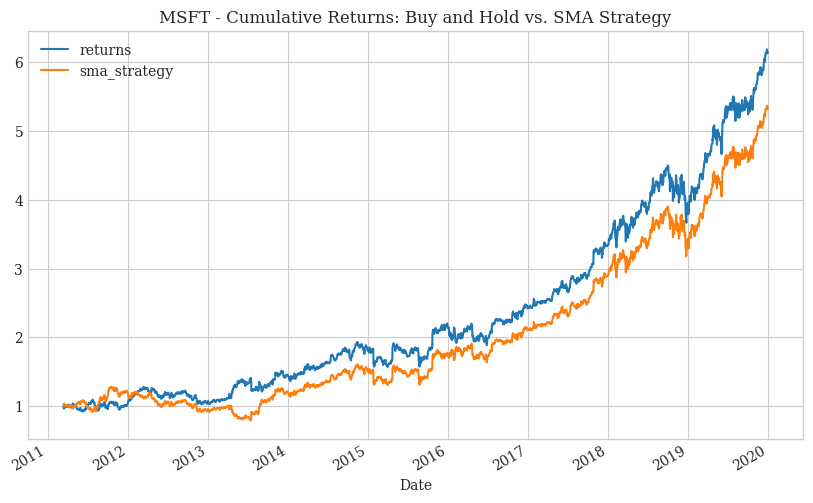

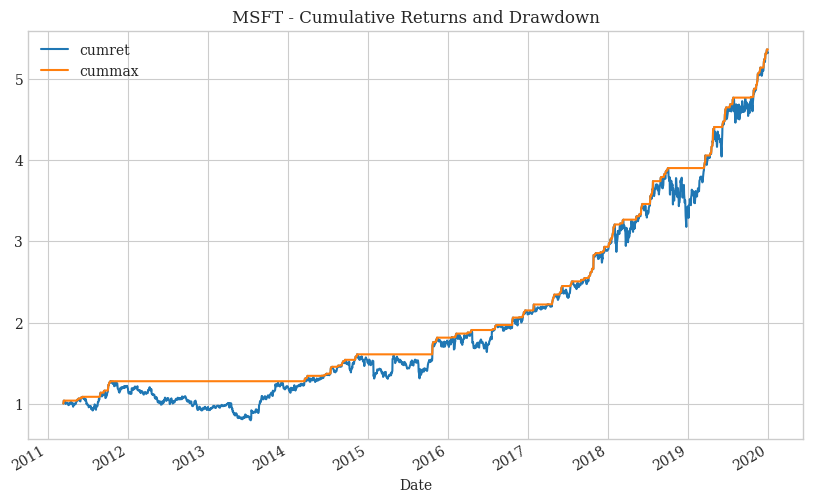

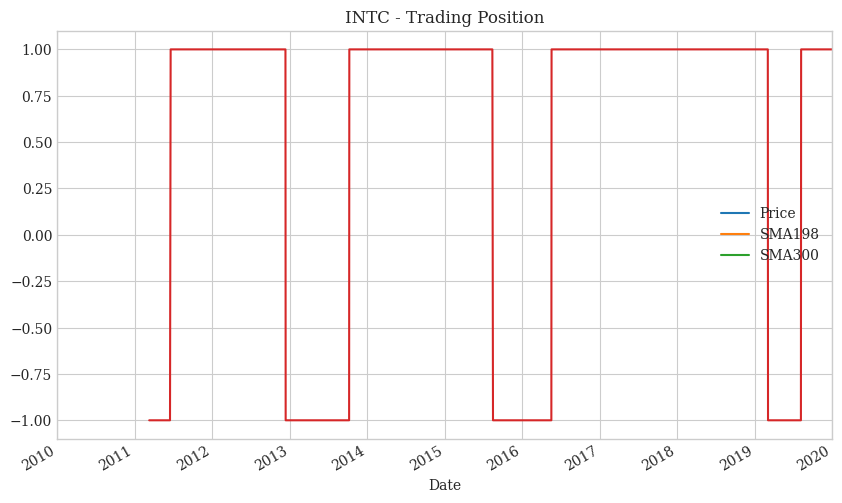

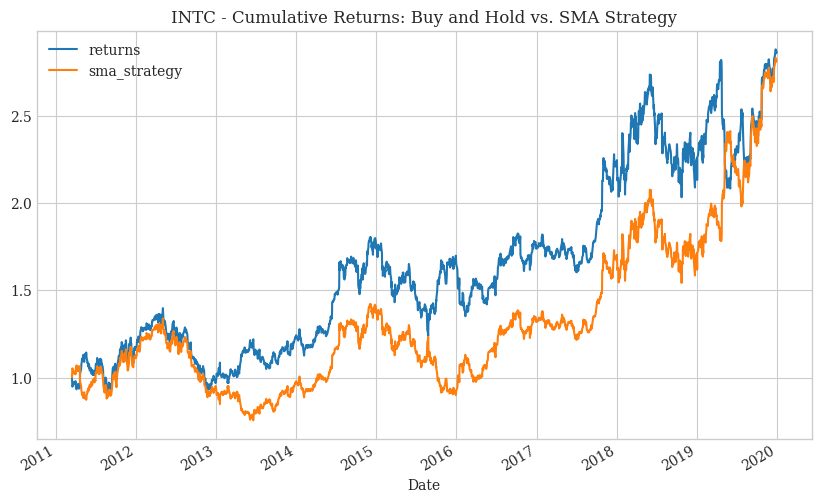

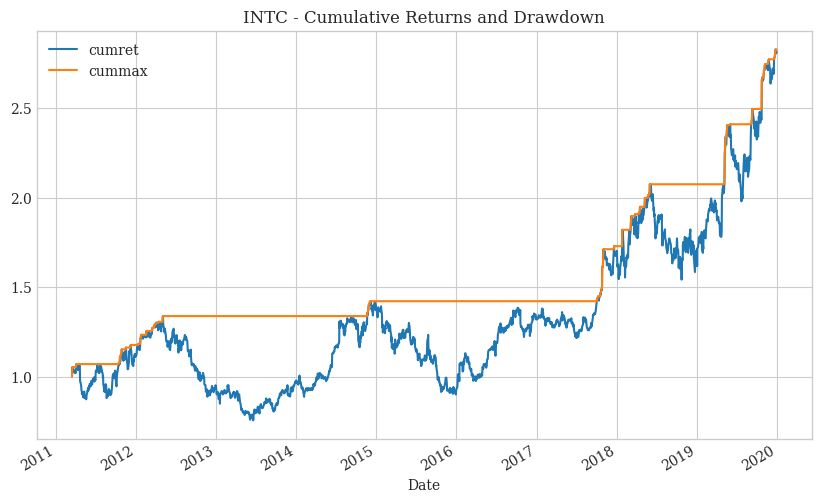

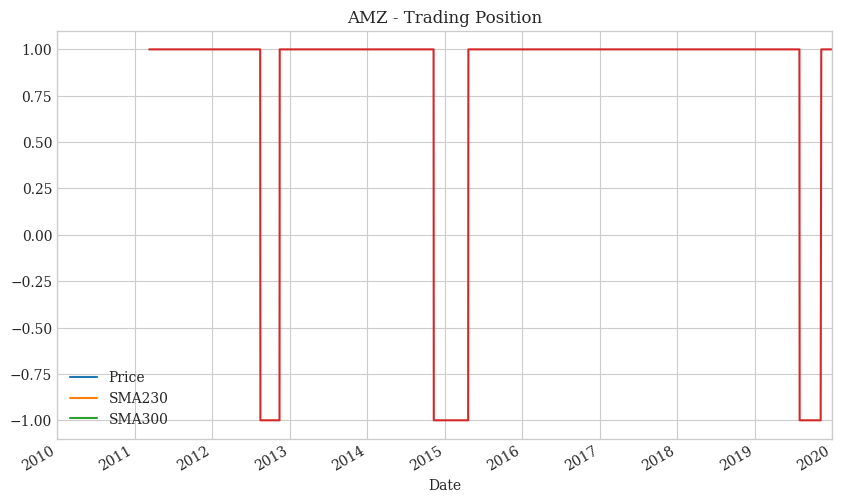

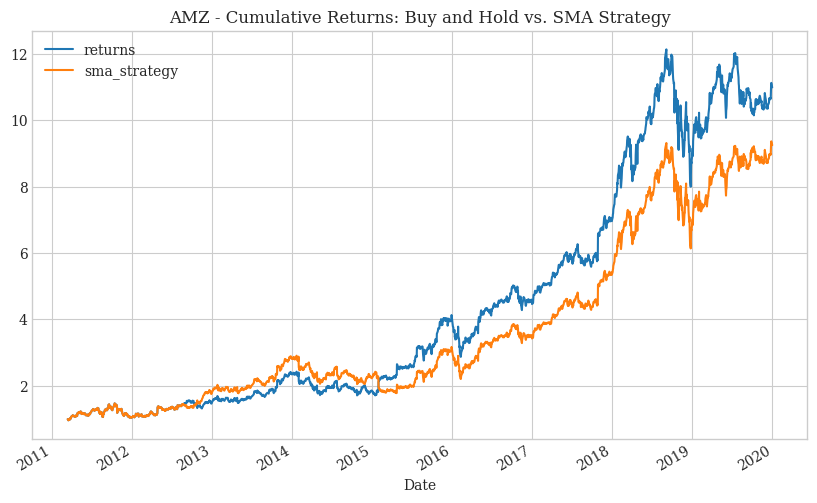

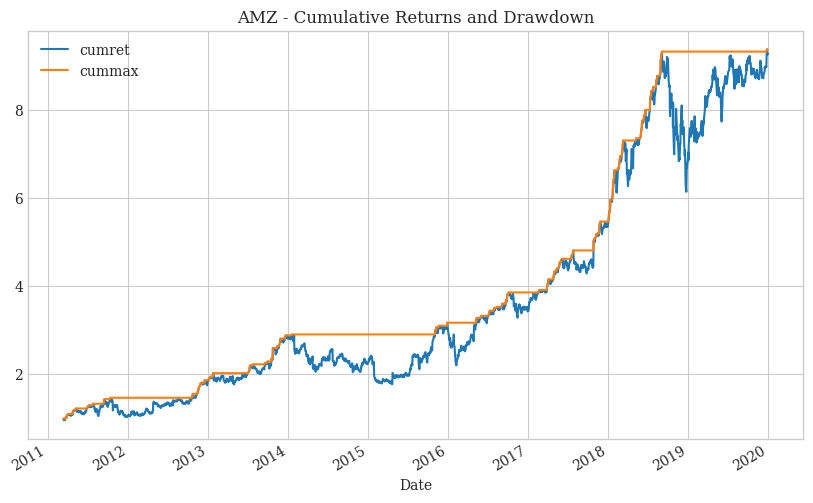

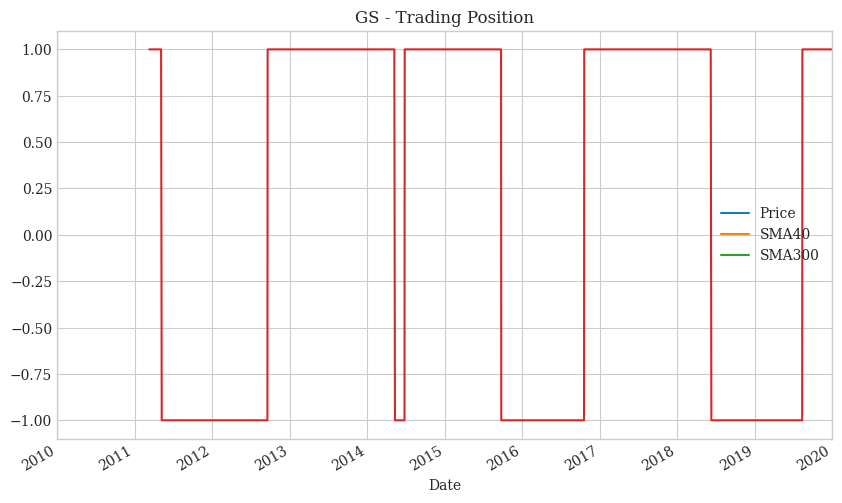

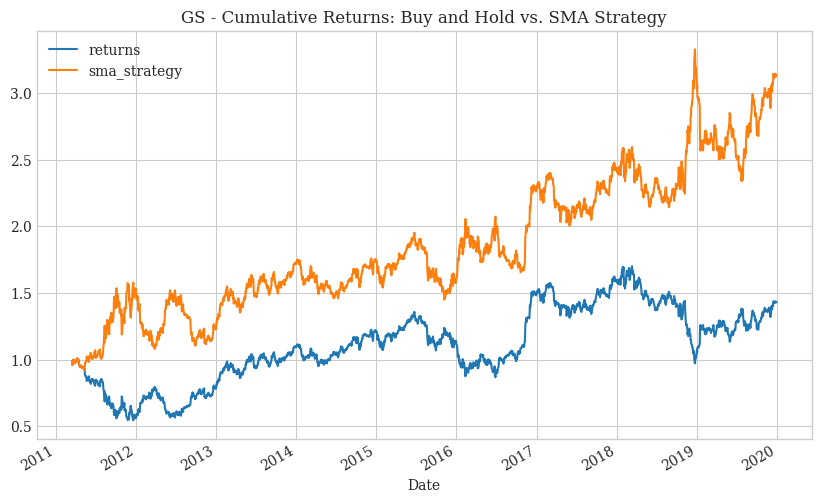

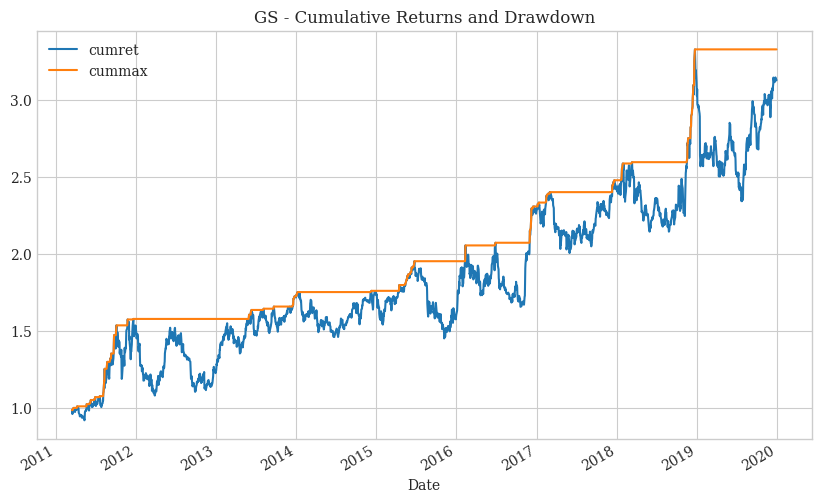

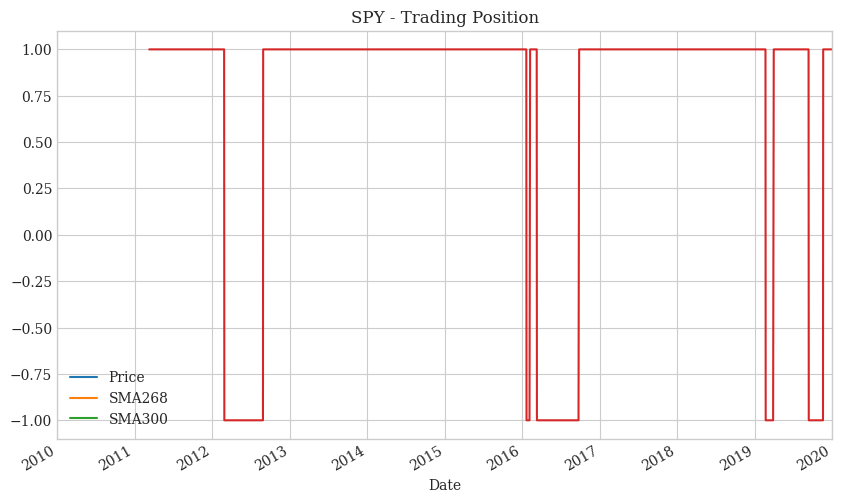

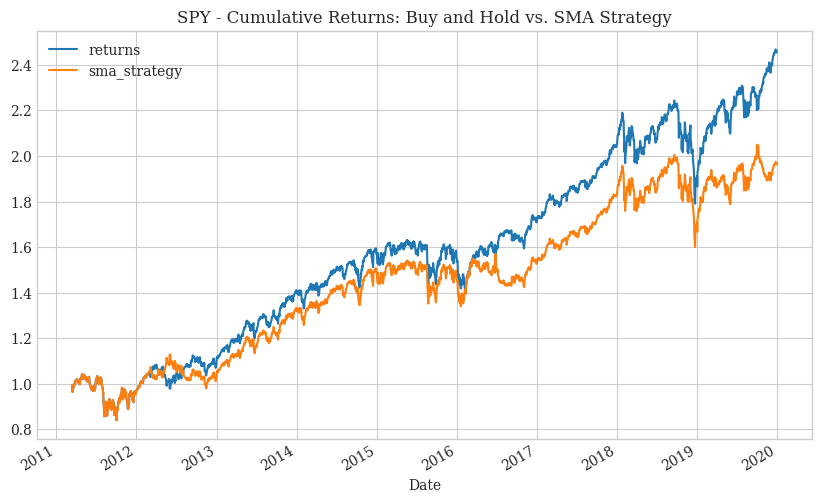

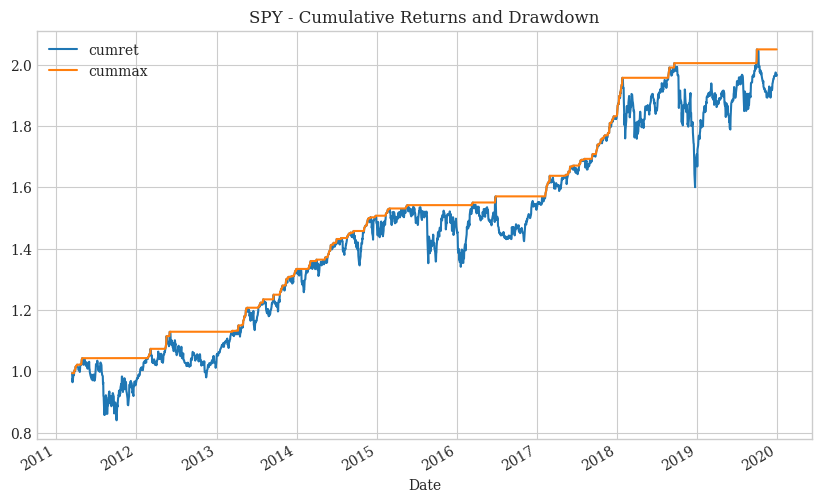

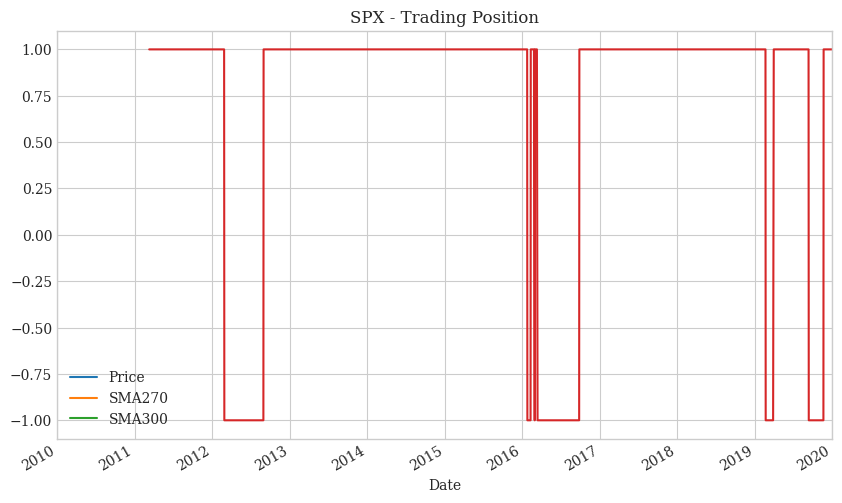

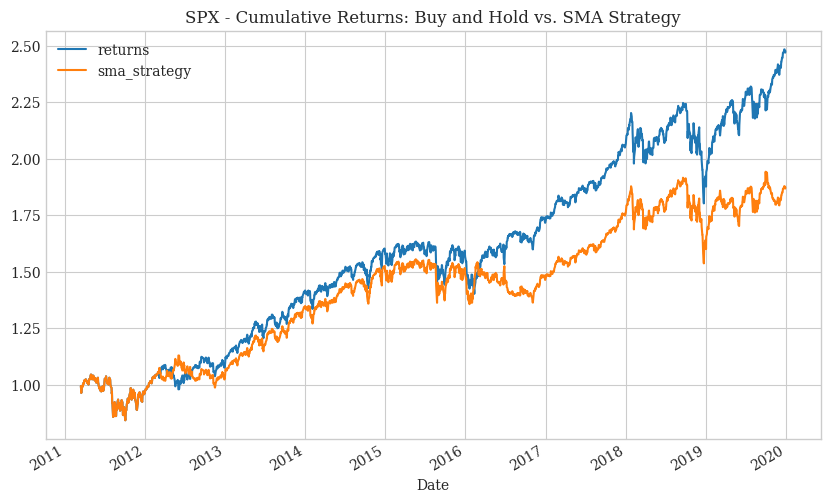

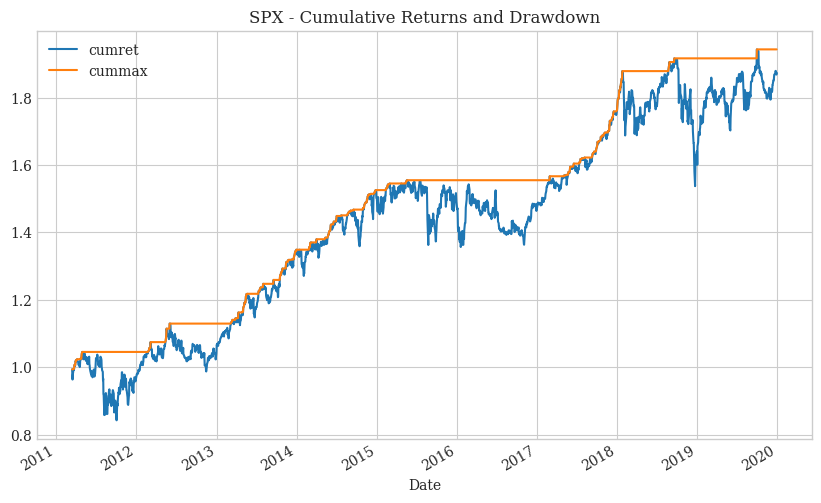

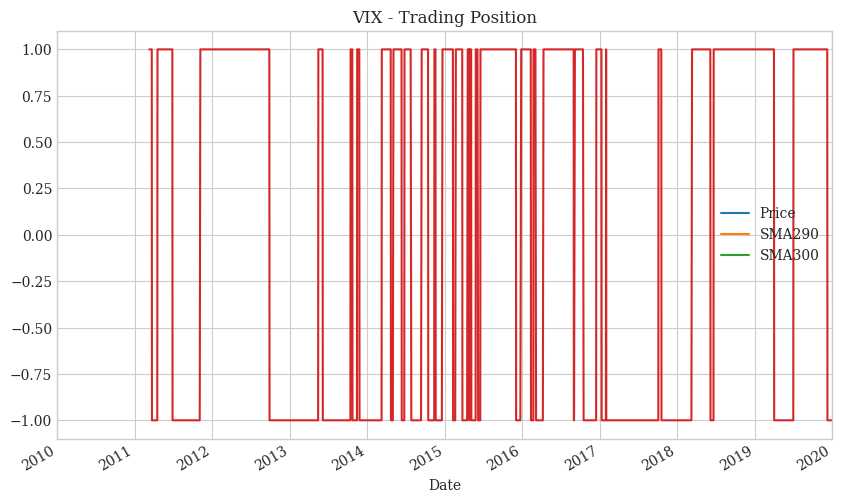

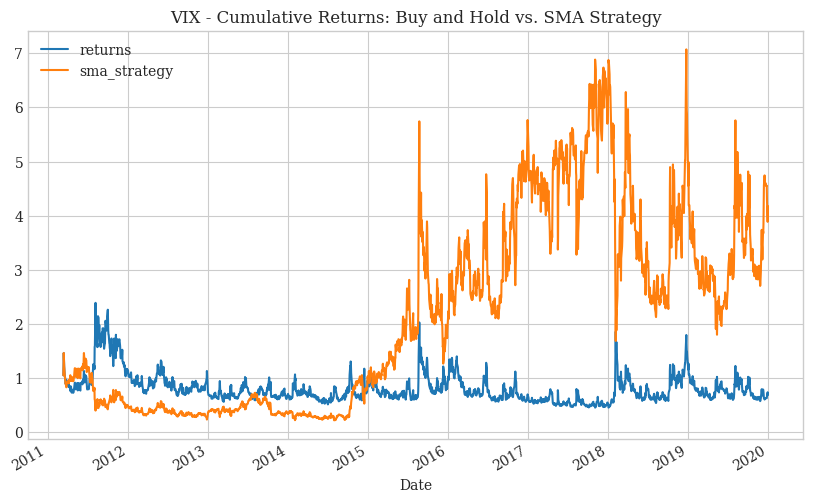

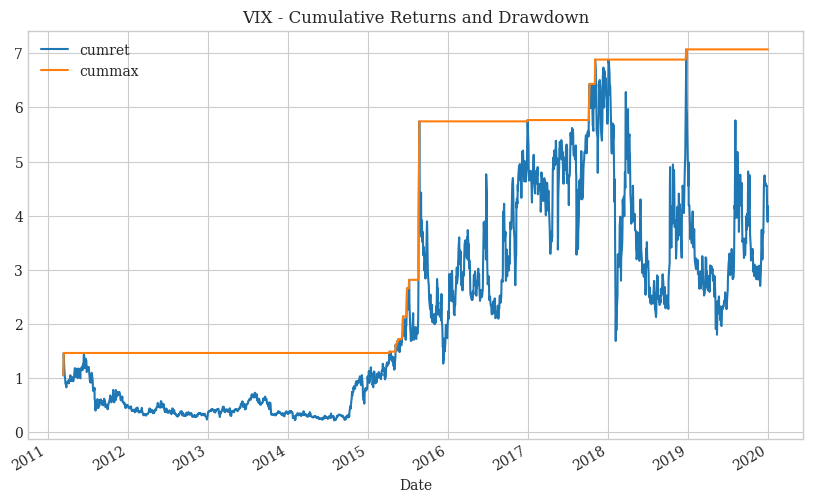

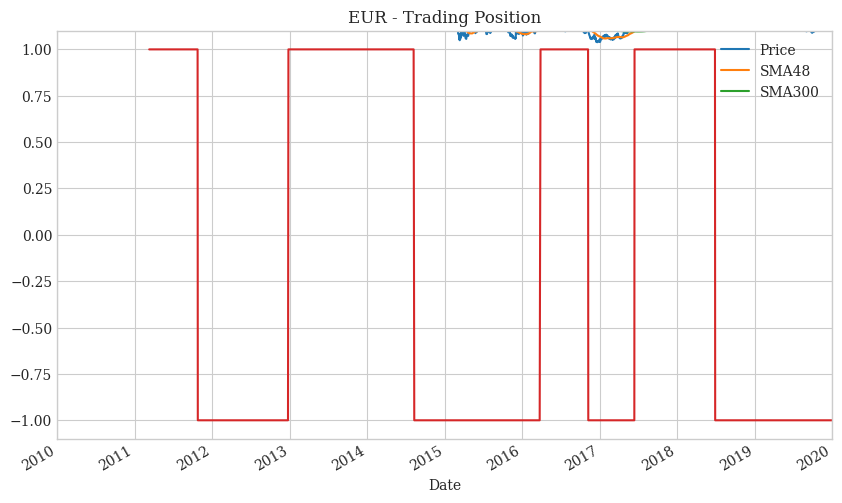

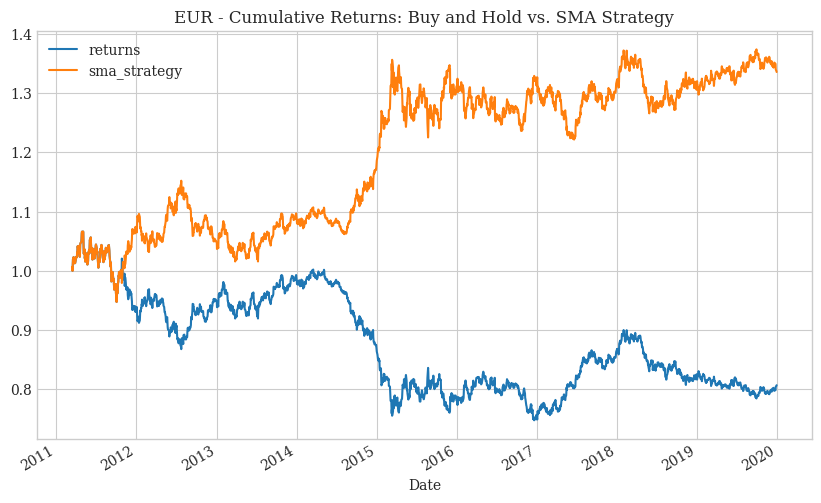

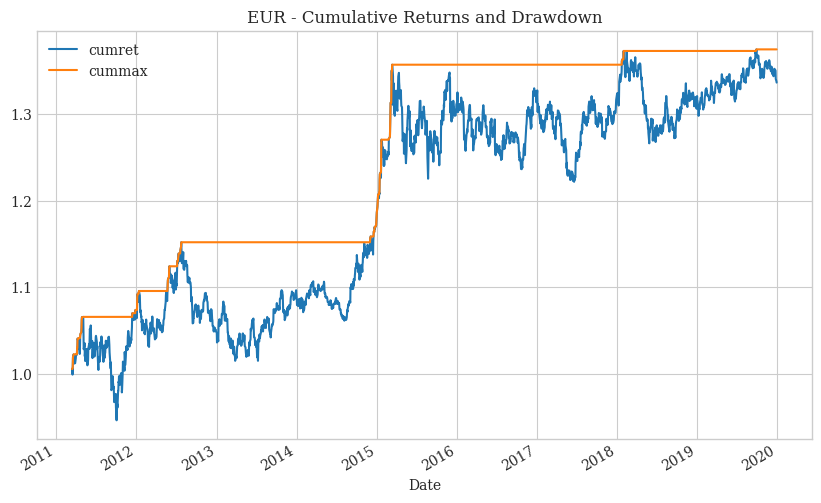

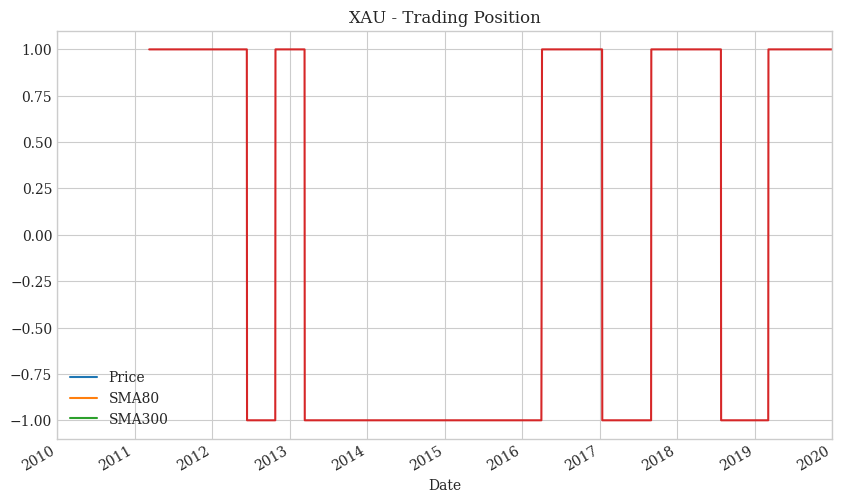

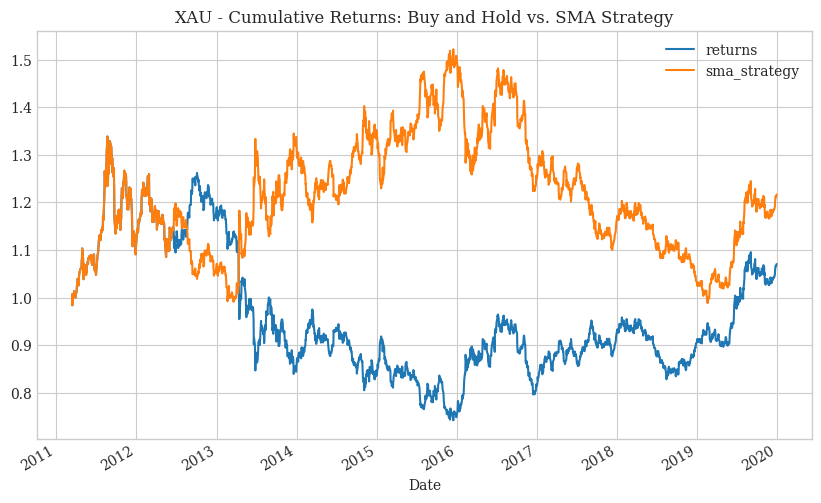

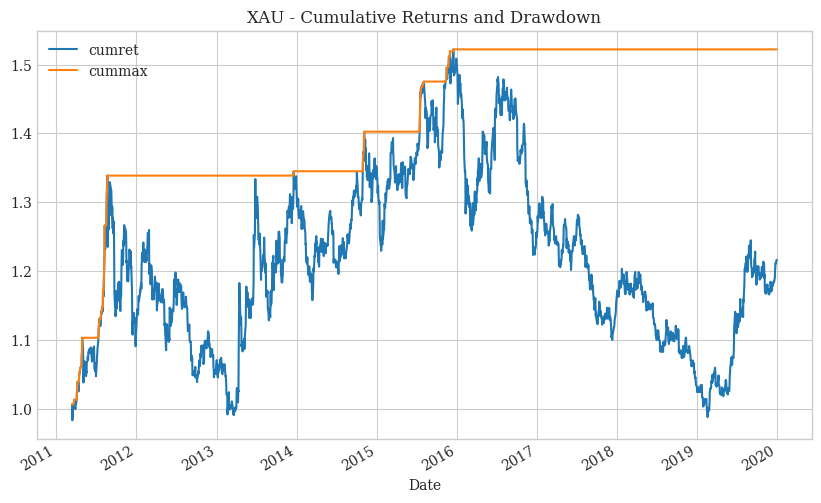

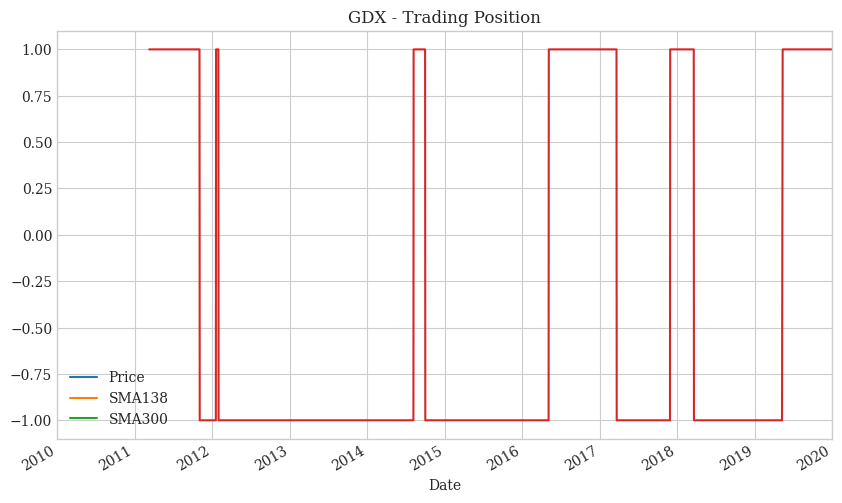

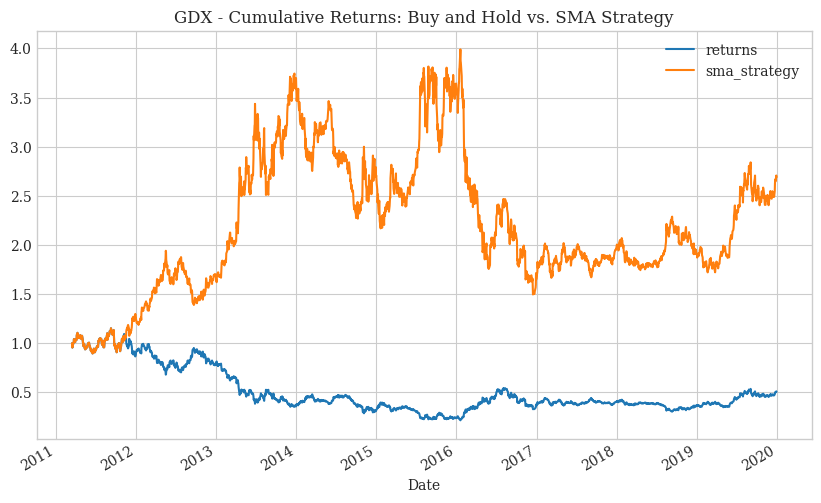

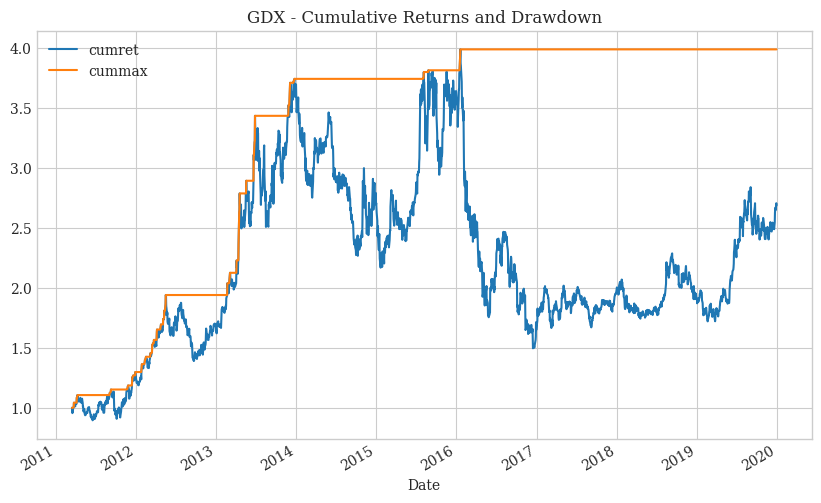

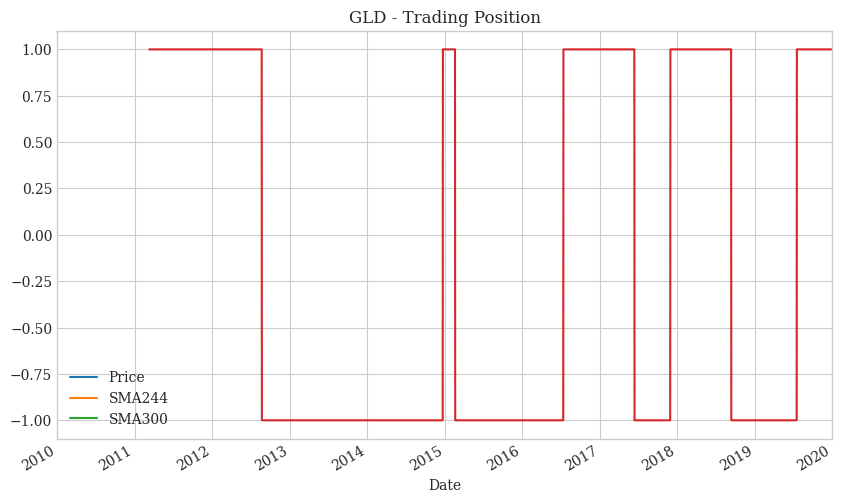

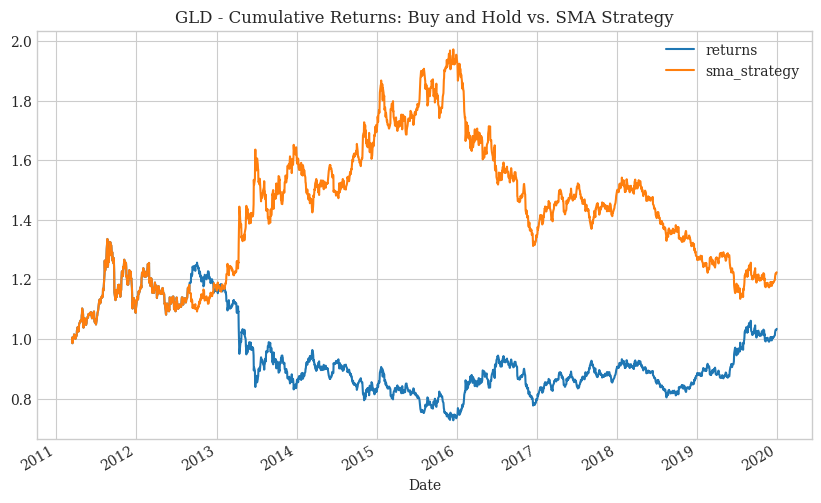

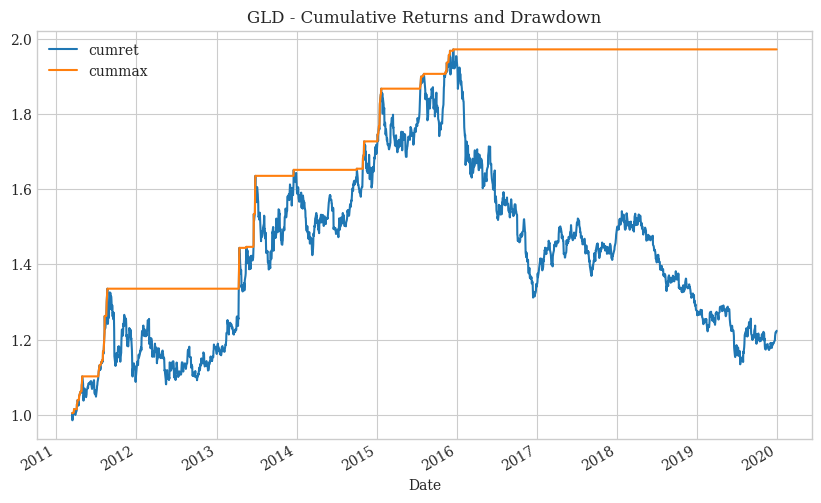

In [34]:
for instrument, optimal_config in instrument_optimal_config.items():
    plot_optimal(optimal_sma=optimal_config['Max Returns SMA_1'], SMA_2=300, instrument=instrument)